In [38]:
import torch
import torch.nn as nn
import numpy as np

from datasets.openml_datasets import OpenML_Dataset
from datasets.torch_datasets import Torch_Dataset
from utils.weakener import Weakener
#from models.model import MLP
from models.general_model import MLP
from utils.losses import OSLCELoss
from utils.trainig_testing import train_and_evaluate



In [47]:
Data = Torch_Dataset('mnist', batch_size=256)
Weak = Weakener(Data.num_classes)

In [48]:
Weak.generate_M('pll',pll_p=0.5)
Weak.M,Weak.Z

(array([[0.        , 0.        , 0.        , ..., 0.        , 0.00217014,
         0.00217014],
        [0.        , 0.        , 0.        , ..., 0.00217014, 0.        ,
         0.00217014],
        [0.        , 0.        , 0.        , ..., 0.00217014, 0.00217014,
         0.        ],
        ...,
        [0.00195312, 0.00195312, 0.00195312, ..., 0.00195312, 0.        ,
         0.00195312],
        [0.00195312, 0.00195312, 0.00195312, ..., 0.00195312, 0.00195312,
         0.        ],
        [0.00195312, 0.00195312, 0.00195312, ..., 0.00195312, 0.00195312,
         0.00195312]]),
 array([[0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 1, 0, 1],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [1, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1]]))

In [49]:
train_X,train_y,test_X,test_y =  Data.get_data()
Weak.generate_weak(train_y)
train_y[:5,:],Weak.z[:5],Weak.w[:5,:]

(tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 tensor([583, 679, 427, 806,   4], dtype=torch.int32),
 tensor([[1., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
         [1., 0., 1., 0., 1., 1., 0., 0., 1., 0.],
         [0., 1., 1., 0., 1., 1., 0., 1., 0., 1.],
         [1., 1., 0., 0., 1., 1., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]], dtype=torch.float64))

In [50]:
Data.include_weak(Weak.w)

In [55]:
trainloader,testloader = Data.get_dataloader()

In [56]:
mlp = MLP(Data.num_features,[Data.num_features,Data.num_features],Data.num_classes, dropout_p=0.5, bn=False, activation =  'relu')

In [57]:
optimizer = torch.optim.Adam(mlp.parameters(),lr=1e-3)
loss_fn = OSLCELoss()

In [58]:
mlp, results = train_and_evaluate(mlp, trainloader, testloader, optimizer, loss_fn, num_epochs = 50, sound = 10)

Epoch 10/50: Train Loss: 0.2853, Train Acc: 0.8782, Test Acc: 0.9307
Epoch 20/50: Train Loss: 0.2296, Train Acc: 0.8996, Test Acc: 0.9375
Epoch 30/50: Train Loss: 0.2441, Train Acc: 0.8996, Test Acc: 0.9376
Epoch 40/50: Train Loss: 0.2021, Train Acc: 0.9089, Test Acc: 0.9449
Epoch 50/50: Train Loss: 0.1949, Train Acc: 0.9115, Test Acc: 0.9484


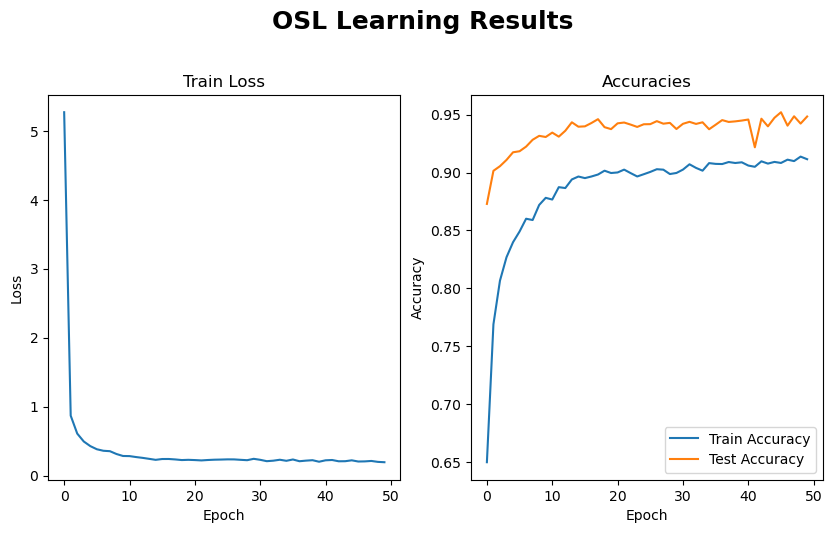

In [59]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot (Train Loss)
ax1.plot(results['train_loss'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train Loss')

# Plot the second subplot (Accuracies)
ax2.plot(results['train_acc'], label='Train Accuracy')
ax2.plot(results['test_acc'], label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracies')
ax2.legend()

fig.suptitle('OSL Learning Results', fontsize=18, fontweight='bold', y=1.05)
# Show the plot
plt.show()

In [62]:
logsoftmax = nn.LogSoftmax(dim = 1)

a,b = torch.max(torch.exp(logsoftmax(mlp(train_X))),dim=1)
b
from collections import Counter
Counter(np.array(b))

Counter({5: 5261,
         0: 5896,
         4: 5583,
         1: 6668,
         9: 6154,
         2: 5712,
         3: 6077,
         6: 5784,
         7: 6233,
         8: 6632})

In [63]:
a1,b1 = torch.max(train_y,dim=1)
b1
from collections import Counter
Counter(np.array(b1))

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

In [66]:
Weak.w.shape

torch.Size([60000, 10])

In [73]:
torch.from_numpy(Weak.Z).type(torch.LongTensor)

tensor([[0, 0, 0,  ..., 0, 1, 1],
        [0, 0, 0,  ..., 1, 0, 1],
        [0, 0, 0,  ..., 1, 1, 0],
        ...,
        [1, 1, 1,  ..., 1, 0, 1],
        [1, 1, 1,  ..., 1, 1, 0],
        [1, 1, 1,  ..., 1, 1, 1]])

In [76]:
M_est = torch.zeros_like(torch.from_numpy(Weak.Z).type(torch.LongTensor))
M_est

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [88]:
a,b = torch.max(torch.exp(logsoftmax(mlp(train_X))),dim=1)
for i in range(60000):
    M_est[Weak.z[i],b[i]] += 1


In [89]:
M_prob = M_est/torch.sum(M_est,dim=0,keepdim=True)

In [ ]:
Counter(np.array(b))
P_y =

In [90]:
torch.

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [94]:
x = torch.tensor([1, 2, 3])
x.repeat(2, 1).T

tensor([[1, 1],
        [2, 2],
        [3, 3]])

In [75]:
Çfor inputs, vl, targets, ind in trainloader:
    optimizer.zero_grad()
    outputs = mlp(inputs)
    loss = loss_fn(outputs, vl)
    loss.backward()
    optimizer.step()

KeyboardInterrupt: 